***
### Import modules : 

In [2]:
import os 
import pandas as pd 
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


***
### Read the matrices :

In [3]:
path_finetuning = "/media/concha-eloko/Linux/PPT_clean/in_vitro/fine_tuning"

bea_df = pd.read_csv(f"{path_finetuning}/bea_fine_tuning.df", sep = "\t", header = 0)
bea_df["Protein"] = bea_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_bea = set([kltype.strip() for kltypes in bea_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

ferriol_df = pd.read_csv(f"{path_finetuning}/ferriol_fine_tuning.df", sep = "\t", header = 0)
#ferriol_df["Target"] = ferriol_df["Target"].apply(lambda x : x.replace("K", "KL"))
pool_ferriol = set([kltype.strip() for kltypes in ferriol_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

towndsend_df = pd.read_csv(f"{path_finetuning}/towndsend_fine_tuning.df", sep = "\t", header = 0)
towndsend_df["Protein"] = towndsend_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_towndsend = set([kltype.strip() for kltypes in towndsend_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

dico_matrices = {"ferriol" : {"matrix" : ferriol_df, "pool" : pool_ferriol}, 
                 "bea" : {"matrix": bea_df, "pool" : pool_bea}, 
                 "towndsend" : {"matrix" : towndsend_df, "pool" : pool_towndsend}}

# targets dico : 
dico_hits = {}
for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for _, row in matrix.iterrows() : 
        for phage in matrix["Phages"].unique() : 
            all_targets = set()
            targets = matrix[matrix["Phages"] == phage]["Target"].values
            for calls in targets : 
                actual_targets = [x.strip() for x in calls.split(",")]
                all_targets.update(actual_targets)
            dico_hits[phage] = all_targets



> TropiGATv2 DF : 

In [4]:
from collections import Counter

path_project = "/media/concha-eloko/Linux/PPT_clean"

DF_info = pd.read_csv(f"{path_project}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)

DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

KLtypes = [kltype for kltype in dico_prophage_count if dico_prophage_count[kltype] >= 20]



***
## Compiling the TropiGAT and TropiSeq predictions :

In [10]:
import pandas as pd 
import os 

path_project = "/media/concha-eloko/Linux/PPT_clean"

tropigat_results = pd.read_csv(f"{path_project}/TropiGAT.results.classic_1007.tsv", sep = "\t", names = ["protein", "predictions_tropigat"])
seqbased_results = pd.read_csv(f"{path_project}/Seqbased_model.results.bit75.1007.tsv", sep = "\t", names = ["protein", "predictions_seqbased"])

fold_phages_df = pd.read_csv(f"{path_project}/in_vitro/dpos_folds.all_matrices.tsv", sep = "\t", header = 0)


In [11]:
sorted(tropigat_results.protein.tolist())

['A1a_00002',
 'A1a_00014',
 'A1b_00036',
 'A1b_00048',
 'A1c_00034',
 'A1c_00046',
 'A1d_00009',
 'A1d_00013',
 'A1e_00012',
 'A1e_00024',
 'A1f_00012',
 'A1f_00024',
 'A1g_00045',
 'A1g_00057',
 'A1h_00009',
 'A1h_00013',
 'A1h_00021',
 'A1i_00037',
 'A1i_00041',
 'A1i_00049',
 'A1j_00002',
 'A1j_00040',
 'A1j_00049',
 'A1k_00014',
 'A1k_00018',
 'A1l_00005',
 'A1l_00058',
 'A1m_00045',
 'A1m_00049',
 'A1n_00050',
 'A1o_00041',
 'A1o_00045',
 'A1p_00055',
 'A1q_00010',
 'A1q_00019',
 'A1q_00023',
 'A1r_00009',
 'A1r_00013',
 'A2a_00010',
 'A2a_00049',
 'A2a_b_00022',
 'A2a_b_00036',
 'A2b_00008',
 'A2b_00022',
 'A3a_00002',
 'A3a_00045',
 'A3b_00016',
 'A3b_00021',
 'A3c_00039',
 'A3c_00044',
 'A3c_00045',
 'A3d_00036',
 'A3d_00041',
 'A3d_00042',
 'BLCJPOBP_00041',
 'BLCJPOBP_00052',
 'D7b_00043',
 'D7c_00007',
 'DIMCIIMF_00039',
 'DIMCIIMF_00240',
 'DJLANJJD_00238',
 'EHPPICDA_00095',
 'EKPIEFBL_00113',
 'EKPIEFBL_00177',
 'EONHMLJF_00087',
 'FADJDIKG_00019',
 'FADJDIKG_00083',
 'G

In [12]:
set_depolymerases = set(fold_phages_df["protein_id"].tolist())

In [13]:
tropigat_results["clean_name"] = tropigat_results["protein"].apply(lambda x : x if x.count("Dpo_domain") == 0 else x.split("_Dpo")[0])
tropigat_pred = set(tropigat_results["clean_name"].tolist())

In [15]:
set_depolymerases - tropigat_pred

{'K41P2__cds_226', 'K62PH164C2__cds_25', 'K65PH164__cds_197'}

In [16]:
seqbased_results["clean_name"] = seqbased_results["protein"].apply(lambda x : x if x.count(" ") == 0 else "__".join(x.split(" ")))
tropiseq_pred = set(seqbased_results["clean_name"].tolist())

In [17]:
tropiseq_pred - tropigat_pred

{'K33PH14C2__cds_55', 'K62PH164C2__cds_25'}

In [18]:
tropigat_pred - tropiseq_pred

{'BLCJPOBP_00052', 'K42PH8'}

In [19]:
len(tropigat_pred), len(tropiseq_pred)

(269, 269)

> Merge the DFs :

In [68]:
#tropigat_results["protein_id"] = tropigat_results["protein"].apply(lambda x : x if x.count("Dpo_domain") == 0 else x.split("_Dpo")[0])
#seqbased_results["protein_id"] = seqbased_results["protein"].apply(lambda x : x.split("_A")[0] if x.count("_A")>0 else "__".join(x.split(",")[0].split(" ")) if x.count(",")>0 else x)
#merged_df = tropigat_results.merge(seqbased_results, on='protein_id', how='inner')
#merged_df["phage"] = merged_df["protein_id"].apply(lambda x : x.split("__")[0] if x.count("__")>0 else x.split("_")[0])
#merged_df_sorted = merged_df.sort_values(by='phage', ascending=True)


In [20]:
tropigat_results["protein_id"] = tropigat_results["protein"].apply(lambda x : x if x.count("Dpo_domain") == 0 else x.split("_Dpo")[0])
seqbased_results["protein_id"] = seqbased_results["protein"].apply(lambda x : x if x.count(" ") == 0 else "__".join(x.split(" ")))
merged_df = tropigat_results.merge(seqbased_results, on='protein_id', how='inner')
merged_df["phage"] = merged_df["protein_id"].apply(lambda x : x.split("__")[0] if x.count("__")>0 else x.split("_")[0])
merged_df_sorted = merged_df.sort_values(by='phage', ascending=True)


In [21]:
merged_df_sorted

,protein_x,predictions_tropigat,clean_name_x,protein_id,protein_y,predictions_seqbased,clean_name_y,phage
203,A1a_00002,KL123:0.977 ; KL14:0.911 ; KL13:0.9 ; KL39:0.8...,A1a_00002,A1a_00002,A1a_00002,KL102:0.737,A1a_00002,A1a
188,A1a_00014,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,A1a_00014,A1a_00014,A1a_00014,KL151:0.599,A1a_00014,A1a
181,A1b_00036,KL7:0.983 ; KL13:0.975 ; KL123:0.971 ; KL14:0....,A1b_00036,A1b_00036,A1b_00036,KL102:0.737,A1b_00036,A1b
189,A1b_00048,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,A1b_00048,A1b_00048,A1b_00048,No_associations,A1b_00048,A1b
212,A1c_00046,KL13:0.958 ; KL123:0.951 ; KL19:0.92 ; KL14:0....,A1c_00046,A1c_00046,A1c_00046,KL102:0.737,A1c_00046,A1c
...,...,...,...,...,...,...,...,...
211,S13a_00036,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,S13a_00036,S13a_00036,S13a_00036,No_associations,S13a_00036,S13a
173,S13b_00058,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,S13b_00058,S13b_00058,S13b_00058,KL63:0.641,S13b_00058,S13b
205,S13c_00055,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,S13c_00055,S13c_00055,S13c_00055,No_associations,S13c_00055,S13c
204,S13d_00057,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,S13d_00057,S13d_00057,S13d_00057,KL14:0.951,S13d_00057,S13d


In [23]:
final_df = merged_df_sorted[["phage","protein_id", "predictions_seqbased", "predictions_tropigat"]]
final_df.to_csv(f"{path_project}/PPT_results.classic_1007.bit75.tsv", sep = "\t", header = True, index = False)

In [24]:
final_df

,phage,protein_id,predictions_seqbased,predictions_tropigat
203,A1a,A1a_00002,KL102:0.737,KL123:0.977 ; KL14:0.911 ; KL13:0.9 ; KL39:0.8...
188,A1a,A1a_00014,KL151:0.599,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...
181,A1b,A1b_00036,KL102:0.737,KL7:0.983 ; KL13:0.975 ; KL123:0.971 ; KL14:0....
189,A1b,A1b_00048,No_associations,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...
212,A1c,A1c_00046,KL102:0.737,KL13:0.958 ; KL123:0.951 ; KL19:0.92 ; KL14:0....
...,...,...,...,...
211,S13a,S13a_00036,No_associations,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....
173,S13b,S13b_00058,KL63:0.641,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....
205,S13c,S13c_00055,No_associations,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...
204,S13d,S13d_00057,KL14:0.951,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....


In [6]:
df_folds = pd.read_csv(f"{path_project}/in_vitro/dpos_folds.all_matrices.tsv", header = 0, sep = "\t")


In [5]:
path_finetuning = "/media/concha-eloko/Linux/PPT_clean/in_vitro/fine_tuning"

bea_df = pd.read_csv(f"{path_finetuning}/bea_fine_tuning.df", sep = "\t", header = 0)
bea_df["Protein"] = bea_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_bea = set([kltype.strip() for kltypes in bea_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

ferriol_df = pd.read_csv(f"{path_finetuning}/ferriol_fine_tuning.df", sep = "\t", header = 0)
#ferriol_df["Target"] = ferriol_df["Target"].apply(lambda x : x.replace("K", "KL"))
pool_ferriol = set([kltype.strip() for kltypes in ferriol_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

towndsend_df = pd.read_csv(f"{path_finetuning}/towndsend_fine_tuning.df", sep = "\t", header = 0)
towndsend_df["Protein"] = towndsend_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_towndsend = set([kltype.strip() for kltypes in towndsend_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

dico_matrices = {"ferriol" : {"matrix" : ferriol_df, "pool" : pool_ferriol}, 
                 "bea" : {"matrix": bea_df, "pool" : pool_bea}, 
                 "towndsend" : {"matrix" : towndsend_df, "pool" : pool_towndsend}}


# targets dico : 
dico_hits = {}
for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for _, row in matrix.iterrows() : 
        for phage in matrix["Phages"].unique() : 
            all_targets = set()
            targets = matrix[matrix["Phages"] == phage]["Target"].values
            for calls in targets : 
                actual_targets = [x.strip() for x in calls.split(",")]
                all_targets.update(actual_targets)
            dico_hits[phage] = all_targets

In [25]:
top_n = 40

path_project = "/media/concha-eloko/Linux/PPT_clean"

# Classic version : 
tropigat_results = pd.read_csv(f"{path_project}/PPT_results.classic_1007.bit75.tsv", header = 0, sep = "\t")

with open(f"{path_project}/raw_metrics.classic_1007.bit75.top40.detailed.tsv", "w") as outfile :
    outfile.write(f"Phage\tProtein\tFolds\tTropiGAT_predictions\tTropiGAT_good_calls\tTropiSeq_predictions\tTropiSeq_good_calls\tTargets\n")
    for _, row in tropigat_results.iterrows() : 
        if row["phage"] in dico_hits :
            targets = dico_hits[row["phage"]]
            prot_id = row['protein_id'].replace("__cds", "_cds")
            try : 
                #targets = dico_hits[row["phage"]]
                #prot_id = row['protein_id'].replace("__cds", "_cds")
                fold = df_folds[df_folds["protein_id"] == row['protein_id']]["Fold"].values[0]
            except Exception as e :
                fold = "unknown"
            outfile.write(f"{row['phage']}\t{row['protein_id']}\t{fold}\t")
            # TropiGAT part : 
            # write the pred
            top_n_predictions = ";".join([x for x in row["predictions_tropigat"].split(";")][0:top_n-1])
            outfile.write(top_n_predictions + "\t")
            # check the calls
            tropigat_pred = [x.split(":")[0].strip() for x in row["predictions_tropigat"].split(";")]
            top_KLtypes_pred = set(tropigat_pred[0: top_n-1])
            good_calls = top_KLtypes_pred.intersection(targets)
            if len(good_calls) > 0 : 
                outfile.write(",".join(list(good_calls)) + "\t")
            else : 
                outfile.write("0" + "\t")
            # TropiSeq part : 
            # write the pred
            outfile.write(row["predictions_seqbased"] + "\t")
            if row["predictions_seqbased"] != "No hits" and row["predictions_seqbased"] != "No predictions" : 
                tropiseq_pred = [x.split(":")[0].strip() for x in row["predictions_seqbased"].split(";")]
                top_predictions = set(tropiseq_pred[0: top_n-1])
                good_calls = top_predictions.intersection(targets)
                if len(good_calls) > 0 : 
                    outfile.write(",".join(list(good_calls)) + "\t")
                else :
                    outfile.write("0" + "\t")
            else :
                outfile.write("0\t")
            target_clean = ",".join(list(targets))
            outfile.write(target_clean + "\n")


    

***
## Working on the final matrices file :

In [2]:
import os 
import pandas as pd 

path_project = "/media/concha-eloko/Linux/PPT_clean"


raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_1007.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]


In [4]:
working_df.to_csv(f"{path_project}/Supplmentary_Table_5.tsv", sep = "\t", header = True, index = False)

In [27]:
raw_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00002,6-bladed beta-propeller,KL123:0.977 ; KL14:0.911 ; KL13:0.9 ; KL39:0.8...,0,KL102:0.737,0,KL151
1,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
2,A1b,A1b_00036,6-bladed beta-propeller,KL7:0.983 ; KL13:0.975 ; KL123:0.971 ; KL14:0....,0,KL102:0.737,0,KL157
3,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No_associations,0,KL157
4,A1c,A1c_00046,6-bladed beta-propeller,KL13:0.958 ; KL123:0.951 ; KL19:0.92 ; KL14:0....,0,KL102:0.737,0,KL1
...,...,...,...,...,...,...,...,...
255,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No_associations,0,"KL102,KL149"
256,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
257,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No_associations,0,"KL102,KL149"
258,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [28]:
working_df[working_df["Phage"] == "K13PH07C1L"]

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
80,K13PH07C1L,K13PH07C1L__cds_11,right-handed beta-helix,KL23:0.992 ; KL10:0.99 ; KL30:0.975 ; KL60:0.9...,KL13,KL13:0.527,KL13,KL13
81,K13PH07C1L,K13PH07C1L__cds_12,right-handed beta-helix,KL57:0.997 ; KL70:0.997 ; KL114:0.995 ; KL60:0...,KL13,No_associations,0,KL13
82,K13PH07C1L,K13PH07C1L__cds_10,right-handed beta-helix,KL46:0.989 ; KL23:0.927 ; KL74:0.802 ; KL19:0....,0,KL3:0.511,0,KL13
83,K13PH07C1L,K13PH07C1L__cds_54,6-bladed beta-propeller,KL19:0.969 ; KL7:0.932 ; KL13:0.931 ; KL14:0.8...,KL13,KL102:0.737,0,KL13


***
### Make the matrices files : 

In [29]:
from tqdm import tqdm

top_n = 15
labels_tropigat = {}
count_kltypes = {}

for kltype in tqdm(dico_prophage_count) : 
    n = 0
    pred_labels , real_labels = [] , []
    for author in dico_matrices :
        if kltype in dico_matrices[author]["pool"] : 
            matrix = dico_matrices[author]["matrix"]
            for phage in matrix["Phages"].unique() :
                top_predictions = set()
                predictions = working_df[working_df["Phage"] == phage]["TropiGAT_predictions"].values
                for calls in predictions : 
                    predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                    top_predictions.update(predicted_kltypes[0:top_n-1])
                if kltype in top_predictions : 
                    pred_labels.append(1)
                else : 
                    pred_labels.append(0)
                if kltype in dico_hits[phage] : 
                    real_labels.append(1)
                    n += 1 
                else :
                    real_labels.append(0)
    labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
    count_kltypes[kltype] = n 

labels_tropigat
sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 134.54it/s]


In [30]:
def make_labels(pred_df, predictor = "tropigat" , top_n = 15, to_ignore = []) :
    dico_pred = {"tropigat" : "TropiGAT_predictions" ,
                 "tropiseq" : "TropiSeq_predictions"}
    col = dico_pred[predictor]
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        predictions = pred_df[pred_df["Phage"] == phage][col].values
                        for calls in predictions : 
                            predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                            top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes


def decript_dic (sorted_dict , labels_tropigat, count_kltypes) :
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")



### Work on TropiGAT : 

> Full predictions : 

In [13]:
tropigat_results_gat = tropigat_results[(tropigat_results["Targets"].str.count("pass") == 0)]

sorted_dic_tropigat, labels_tropigat, count_kltypes = make_labels(tropigat_results_gat, to_ignore = phages_to_ignore)
decript_dic(sorted_dic_tropigat, labels_tropigat, count_kltypes)

100%|████████████████████████████████████████| 128/128 [00:01<00:00, 114.62it/s]


KL1	3	0.0	0.90909	0.0	0.0	0.46875	-0.0449
KL2	16	0.32258	0.82353	0.3125	0.33333	0.60771	0.22141
KL3	12	0.42105	0.45	0.33333	0.57143	0.47917	-0.0428
KL5	1	0.0	0.64062	0.0	0.0	0.3254	-0.09118
KL7	2	0.0	0.4375	0.0	0.0	0.22581	-0.1912
KL8	1	0.0	0.85938	0.0	0.0	0.43651	-0.04762
KL9	1	0.14286	0.8125	1.0	0.07692	0.90476	0.24954
KL10	1	0.2	0.875	1.0	0.11111	0.93651	0.31145
KL12	1	0.0	0.8125	0.0	0.0	0.4127	-0.0574
KL13	3	0.09524	0.42424	1.0	0.05	0.70312	0.14252
KL14	10	0.06897	0.31933	0.3	0.03896	0.31055	-0.21997
KL15	1	0.05714	0.48438	1.0	0.02941	0.7381	0.11835
KL16	4	0.4	0.97479	0.25	1.0	0.625	0.4936
KL17	2	0.4	0.95312	0.5	0.33333	0.73387	0.38503
KL18	1	0.04444	0.32812	1.0	0.02273	0.65873	0.08494
KL19	1	0.06452	0.54688	1.0	0.03333	0.76984	0.13412
KL21	1	0.28571	0.92188	1.0	0.16667	0.96032	0.39171
KL22	10	0.53846	0.87879	0.7	0.4375	0.79944	0.49027
KL23	1	0.0	0.70312	0.0	0.0	0.35714	-0.07881
KL24	5	0.26667	0.88889	0.4	0.2	0.65745	0.22883
KL25	3	0.21429	0.77778	1.0	0.12	0.88542	0.30414
KL27	2	0.

***
> Work on TropiSeq :

In [15]:
sorted_dic_tropiseq, labels_tropiseq, count_kltypes = make_labels(tropigat_results, predictor = "tropiseq",  to_ignore = phages_to_ignore)
decript_dic(sorted_dic_tropiseq, labels_tropiseq, count_kltypes)

100%|████████████████████████████████████████| 128/128 [00:01<00:00, 111.69it/s]


KL2	16	0.28571	0.87903	0.1875	0.6	0.58449	0.28797
KL3	12	0.4	0.59091	0.25	1.0	0.625	0.36274
KL4	7	0.25	0.93023	0.14286	1.0	0.57143	0.36438
KL9	1	0.66667	0.98438	1.0	0.5	0.99206	0.70147
KL13	3	0.5	0.98039	0.33333	1.0	0.66667	0.57161
KL14	10	0.16667	0.91935	0.1	0.5	0.54561	0.19719
KL15	1	1.0	1.0	1.0	1.0	1.0	1.0
KL16	4	0.57143	0.97581	0.5	0.66667	0.74583	0.56538
KL17	2	0.66667	0.98438	0.5	1.0	0.75	0.70147
KL18	1	0.0	0.95312	0.0	0.0	0.48413	-0.02263
KL20	1	0.0	0.98039	0.0	0.0	0.49505	-0.0099
KL21	1	0.5	0.96875	1.0	0.33333	0.98413	0.56811
KL23	1	0.66667	0.98438	1.0	0.5	0.99206	0.70147
KL24	5	0.4	0.94118	0.4	0.4	0.68454	0.36907
KL25	3	0.85714	0.9902	1.0	0.75	0.99495	0.86164
KL27	2	0.66667	0.98438	0.5	1.0	0.75	0.70147
KL28	14	0.1	0.85484	0.07143	0.16667	0.51299	0.03831
KL30	3	0.33333	0.96078	0.33333	0.33333	0.65657	0.31313
KL31	1	0.0	0.96875	0.0	0.0	0.49206	-0.01587
KL35	7	0.57143	0.93023	0.57143	0.57143	0.76673	0.53345
KL39	3	0.0	0.92188	0.0	0.0	0.48361	-0.03983
KL43	2	0.0	0.95312	0.0	0.0	0.

***
### Good calls : 

In [31]:
import os 
import pandas as pd 
from itertools import product

path_project = "/media/concha-eloko/Linux/PPT_clean"

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]

raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_1007.bit75.top40.detailed.tsv" , sep = "\t", header = 0)
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]


In [32]:
from collections import Counter

Counter(working_df["Folds"])

Counter({'right-handed beta-helix': 139,
         '6-bladed beta-propeller': 75,
         'triple-helix': 34,
         'Alpha-alpha toroid': 1})

In [33]:
len(working_df["Phage"].unique())

126

In [34]:
all_targets = []

for _, row in working_df.iterrows() : 
    all_targets = all_targets + row["Targets"].split(",")
    
len(set(all_targets))

89

> Functions : 

In [35]:
def get_all_combinations(raw_df, to_ignore = []) :
    all_combinations = set()
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_list = list(set(tmp_df["Targets"].tolist()[0].split(",")))
            combinations = set(product([phage], targets_list))
            all_combinations = all_combinations.union(combinations)
    return all_combinations

In [36]:
def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls


In [37]:
def get_bad_calls_metrics(raw_df , top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_bad_calls = []
    TropiSeq_bad_calls = []
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                total_calls += n_targets
                # TropiGAT calls : 
                top_n_predictions_all = []
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    top_n_predictions_all = top_n_predictions_all + top_n_predictions
                bad_call_tropigat = targets_set - set(top_n_predictions_all)
                if len(bad_call_tropigat) > 0 :
                    for kltype in bad_call_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_bad_calls.append(a)                        
                # TropiSeq calls : 
                top_n_predictions_all = []
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    top_n_predictions_all = top_n_predictions_all + top_n_predictions
                bad_call_tropiseq = targets_set - set(top_n_predictions_all)
                if len(bad_call_tropiseq) > 0 :
                    for kltype in bad_call_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_bad_calls.append(a)
    all_calls = set(TropiGAT_bad_calls).union(set(TropiSeq_bad_calls))

    return total_calls, all_calls , TropiGAT_bad_calls , TropiSeq_bad_calls

> All predictions : 

In [38]:
combinations = get_all_combinations(working_df)
len(combinations)
combinations

{('A1a', 'KL151'),
 ('A1b', 'KL157'),
 ('A1c', 'KL1'),
 ('A1d', 'KL20'),
 ('A1g', 'KL16'),
 ('A1h', 'KL13'),
 ('A1h', 'KL2'),
 ('A1i', 'KL126'),
 ('A1j', 'KL126'),
 ('A1j', 'KL61'),
 ('A1k', 'KL22'),
 ('A1k', 'KL37'),
 ('A1l', 'KL22'),
 ('A1l', 'KL37'),
 ('A1m', 'KL22'),
 ('A1m', 'KL37'),
 ('A1n', 'KL22'),
 ('A1n', 'KL37'),
 ('A1o', 'KL22'),
 ('A1o', 'KL37'),
 ('A1p', 'KL22'),
 ('A1p', 'KL37'),
 ('A1q', 'KL22'),
 ('A1q', 'KL37'),
 ('A1r', 'KL22'),
 ('A1r', 'KL37'),
 ('A2a', 'KL126'),
 ('A2b', 'KL126'),
 ('A3b', 'KL30'),
 ('A3c', 'KL61'),
 ('A3d', 'KL134'),
 ('A3d', 'KL61'),
 ('BLCJPOBP', 'KL2'),
 ('D7b', 'KL140'),
 ('D7c', 'KL28'),
 ('DIMCIIMF', 'KL28'),
 ('DJLANJJD', 'KL14'),
 ('DJLANJJD', 'KL144'),
 ('DJLANJJD', 'KL16'),
 ('DJLANJJD', 'KL2'),
 ('DJLANJJD', 'KL28'),
 ('DJLANJJD', 'KL29'),
 ('DJLANJJD', 'KL3'),
 ('DJLANJJD', 'KL38'),
 ('DJLANJJD', 'KL4'),
 ('DJLANJJD', 'KL53'),
 ('DJLANJJD', 'KL57'),
 ('DJLANJJD', 'KL64'),
 ('EHPPICDA', 'KL14'),
 ('EHPPICDA', 'KL3'),
 ('EHPPICDA', 'KL3

In [39]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 40, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)


(328, 133, 115, 49)

In [40]:
115/328

0.35060975609756095

In [57]:
def get_n_KLtypes(calls) : 
    n = len(set([item[1] for item in calls]))
    return n

TropiGAT_good_calls

[('A1h', 'KL2'),
 ('A1h', 'KL13'),
 ('A1k', 'KL22'),
 ('A1l', 'KL22'),
 ('A1m', 'KL22'),
 ('A1o', 'KL22'),
 ('A1q', 'KL22'),
 ('A1r', 'KL22'),
 ('D7c', 'KL28'),
 ('DJLANJJD', 'KL57'),
 ('DJLANJJD', 'KL53'),
 ('DJLANJJD', 'KL14'),
 ('DJLANJJD', 'KL29'),
 ('EHPPICDA', 'KL38'),
 ('EHPPICDA', 'KL57'),
 ('EKPIEFBL', 'KL29'),
 ('EKPIEFBL', 'KL38'),
 ('EKPIEFBL', 'KL74'),
 ('EKPIEFBL', 'KL53'),
 ('EKPIEFBL', 'KL57'),
 ('FADJDIKG', 'KL57'),
 ('FADJDIKG', 'KL53'),
 ('FADJDIKG', 'KL74'),
 ('FADJDIKG', 'KL29'),
 ('GCLPFEGH', 'KL57'),
 ('GCLPFEGH', 'KL38'),
 ('GCLPFEGH', 'KL29'),
 ('HIIECEMK', 'KL2'),
 ('INMBNBLA', 'KL57'),
 ('INMBNBLA', 'KL53'),
 ('INMBNBLA', 'KL38'),
 ('INMBNBLA', 'KL29'),
 ('IPGJFKPH', 'KL57'),
 ('IPGJFKPH', 'KL29'),
 ('K10PH82C1', 'KL10'),
 ('K11PH164C1', 'KL57'),
 ('K13PH07C1L', 'KL13'),
 ('K13PH07C1S', 'KL13'),
 ('K14PH164C1', 'KL14'),
 ('K15PH90', 'KL15'),
 ('K17alfa62', 'KL62'),
 ('K17alfa62', 'KL17'),
 ('K18PH07C1', 'KL18'),
 ('K21lambda1', 'KL21'),
 ('K24PH164C1', 'KL24'

***
### Test whether the proportion of good calls for experimentally validated dpo is higher than here :

In [41]:
import math
from scipy import stats

def z_test_two_proportions(success1, n1, success2, n2, alpha=0.05):
    # Calculate proportions
    p1 = success1 / n1
    p2 = success2 / n2
    
    # Check if sample size is sufficiently large
    if (n1 * p1 < 5 or n1 * (1 - p1) < 5 or
        n2 * p2 < 5 or n2 * (1 - p2) < 5):
        return "Warning: Sample size may not be sufficiently large for accurate results."
    
    # Calculate pooled proportion
    p_pooled = (success1 + success2) / (n1 + n2)
    
    # Calculate standard error
    se = math.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
    
    # Calculate z-statistic
    z = (p1 - p2) / se
    
    # Calculate p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    # Determine if the difference is significant
    significant = p_value < alpha
    
    return {
        "z_statistic": z,
        "p_value": p_value,
        "significant": significant,
        "proportion1": p1,
        "proportion2": p2
    }

# Example usage
success1, n1 = 15, 25  # 40 successes out of 100 trials in group 1
success2, n2 = 133, 328  # 30 successes out of 100 trials in group 2

result = z_test_two_proportions(success1, n1, success2, n2)
print(result)



{'z_statistic': 1.899911299498485, 'p_value': 0.05744476092427542, 'significant': False, 'proportion1': 0.6, 'proportion2': 0.4054878048780488}


***
### Look into the folds : 

In [42]:
import os 
import pandas as pd 
from itertools import product
from collections import defaultdict
from tqdm import tqdm
from statistics import mean

path_project = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_1007.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

> Number of target per fold : 

In [3]:
targets_fold = defaultdict(list)

for fold in working_df["Folds"].unique() :
    for phage in working_df["Phage"].unique() :
        if fold in working_df[working_df["Phage"] == phage]["Folds"].values[0] : 
            targets_arr = working_df[working_df["Phage"] == phage]["Targets"].values[0].split(",")
            n_target = len(targets_arr)
            targets_fold[fold].append(n_target)

In [4]:
targets_fold = defaultdict(list)

for phage in working_df["Phage"].unique() :
    if "6-bladed beta-propeller" in working_df[working_df["Phage"] == phage]["Folds"].values : 
        fold = "6-bladed beta-propeller"
    else :
        fold = "others"
    targets_arr = working_df[working_df["Phage"] == phage]["Targets"].values[0].split(",")
    n_target = len(targets_arr)
    targets_fold[fold].append(n_target)

In [67]:
for fold in targets_fold : 
    print(fold, mean(targets_fold[fold]))

6-bladed beta-propeller 3.136986301369863
others 1.8679245283018868


In [69]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(targets_fold["6-bladed beta-propeller"], targets_fold["others"])
p_value

0.283536107830188

> Rest

In [46]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]
tpl_df = working_df[working_df["Folds"] == "triple-helix"]

In [126]:
working_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
1,A1a,A1a_00002,6-bladed beta-propeller,KL123:0.977 ; KL14:0.911 ; KL13:0.9 ; KL39:0.8...,0,KL102:0.737,0,KL151
2,A1b,A1b_00036,6-bladed beta-propeller,KL7:0.983 ; KL13:0.975 ; KL123:0.971 ; KL14:0....,0,KL102:0.737,0,KL157
3,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No_associations,0,KL157
4,A1c,A1c_00034,right-handed beta-helix,KL52:0.998 ; KL62:0.993 ; KL128:0.981 ; KL43:0...,0,No_hits,0,KL1
...,...,...,...,...,...,...,...,...
245,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No_associations,0,"KL149,KL102"
246,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
247,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No_associations,0,"KL149,KL102"
248,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [132]:
phages_equipped = [phage for phage in working_df["Phage"].unique() if "6-bladed beta-propeller" in working_df[working_df["Phage"] == phage]["Folds"].values if "triple-helix" in working_df[working_df["Phage"] == phage]["Folds"].values]

n_targets_equipped = [len(working_df[working_df["Phage"] == phage]["Targets"].values[0].split(",")) for phage in phages_equipped]
n_targets_equipped

[1, 11, 12, 10, 4, 18, 2, 2, 15, 1, 15]

In [47]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(rhbh_df, top_n = 40, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)

(128, 68, 49, 48)

In [110]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(bp_df, top_n = 40, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)

(229, 48, 48, 1)

In [124]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(tpl_df, top_n = 40, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)

(135, 32, 32, 0)

In [71]:
rhbh_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
3,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No_associations,0,KL157
4,A1c,A1c_00034,right-handed beta-helix,KL52:0.998 ; KL62:0.993 ; KL128:0.981 ; KL43:0...,0,No_hits,0,KL1
7,A1d,A1d_00009,right-handed beta-helix,KL23:0.983 ; KL60:0.979 ; KL52:0.962 ; KL112:0...,0,No_associations,0,KL20
13,A1g,A1g_00057,right-handed beta-helix,KL128:0.922 ; KL43:0.912 ; KL145:0.898 ; KL18:...,0,No_hits,0,KL16
...,...,...,...,...,...,...,...,...
245,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No_associations,0,"KL149,KL102"
246,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
247,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No_associations,0,"KL149,KL102"
248,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [14]:
# TropiGAT
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(rhbh_df, predictor = "tropigat")
dico_mcc_tropigat_rh = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropigat_rh_f = {kltype : dico_mcc_tropigat_rh[kltype] for kltype in dico_mcc_tropigat_rh if dico_mcc_tropigat_rh[kltype]["lytic_phages"]["Count"]>0}

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropigat")
dico_mcc_tropigat_bp = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropigat_bp_f = {kltype : dico_mcc_tropigat_bp[kltype] for kltype in dico_mcc_tropigat_bp if dico_mcc_tropigat_bp[kltype]["lytic_phages"]["Count"]>0}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 311.77it/s]


In [15]:
# TropiSeq
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(rhbh_df, predictor = "tropiseq")
dico_mcc_tropiseq_rh = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropiseq_rh_f = {kltype : dico_mcc_tropiseq_rh[kltype] for kltype in dico_mcc_tropiseq_rh if dico_mcc_tropiseq_rh[kltype]["lytic_phages"]["Count"]>0}

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropiseq")
dico_mcc_tropiseq_bp = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropiseq_bp_f = {kltype : dico_mcc_tropiseq_bp[kltype] for kltype in dico_mcc_tropiseq_bp if dico_mcc_tropiseq_bp[kltype]["lytic_phages"]["Count"]>0}



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 323.16it/s]


> Plots :

In [16]:
from statistics import mean
from scipy.stats import mannwhitneyu

MCC_rhbh_tropigat = [dico_mcc_tropigat_rh_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropigat_rh_f]
MCC_6bp_tropigat = [dico_mcc_tropigat_bp_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropigat_bp_f]

print(mean(MCC_rhbh_tropigat) , mean(MCC_6bp_tropigat))
statistic, p_value = mannwhitneyu(MCC_rhbh_tropigat, MCC_6bp_tropigat)

p_value

0.1353916302859874 0.01099013029206126


0.0008704137189089108

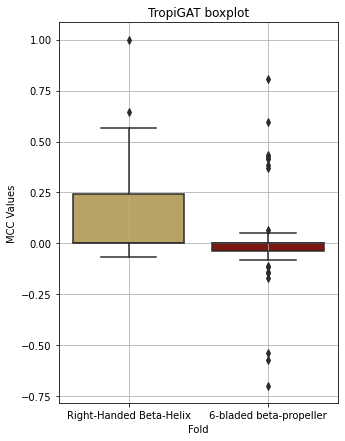

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = MCC_rhbh_tropigat
data2 = MCC_6bp_tropigat

# Combine data and corresponding labels
combined_data = np.concatenate([data1, data2])
labels = ['Right-Handed Beta-Helix'] * len(data1) + ['6-bladed beta-propeller'] * len(data2)

# Create box plot using Seaborn
plt.figure(figsize=(5, 7))
sns.boxplot(x=labels, y=combined_data, palette={'Right-Handed Beta-Helix': '#c6aa58ff', '6-bladed beta-propeller': '#8d0801ff'})

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('MCC Values')
plt.title('TropiGAT boxplot')

# Show plot
plt.grid(True)
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/fold_box_plot.TropiGAT.2806.svg', dpi = 500)
plt.show()

In [17]:
MCC_rhbh_tropiseq = [dico_mcc_tropiseq_rh_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropiseq_rh_f]
MCC_6pb_tropiseq = [dico_mcc_tropiseq_bp_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropiseq_bp_f]

print(mean(MCC_rhbh_tropiseq) , mean(MCC_6pb_tropiseq))
statistic, p_value = mannwhitneyu(MCC_rhbh_tropiseq, MCC_6pb_tropiseq)

p_value

0.33339122960268236 0.007657327468535259


3.199216961511986e-05

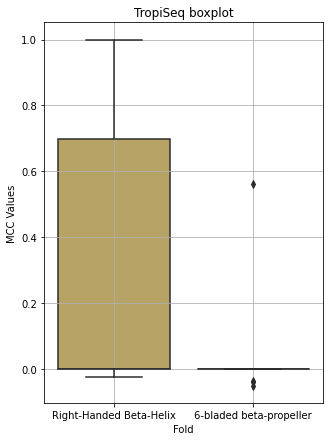

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = MCC_rhbh_tropiseq
data2 = MCC_6pb_tropiseq

# Combine data and corresponding labels
combined_data = np.concatenate([data1, data2])
labels = ['Right-Handed Beta-Helix'] * len(data1) + ['6-bladed beta-propeller'] * len(data2)

# Create box plot using Seaborn
plt.figure(figsize=(5, 7))
sns.boxplot(x=labels, y=combined_data, palette={'Right-Handed Beta-Helix': '#c6aa58ff', '6-bladed beta-propeller': '#8d0801ff'})

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('MCC Values')
plt.title('TropiSeq boxplot')

# Show plot
plt.grid(True)
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/fold_box_plot.TropiSeq.2806.svg', dpi = 500)
plt.show()

In [153]:
dico_mcc_tropiseq_rh_f, dico_mcc_tropigat_rh_f

({'KL1': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 3}},
  'KL2': {'lytic_phages': {'MCC': 0.5947210958240693,
    'Recall': 0.375,
    'Count': 8}},
  'KL3': {'lytic_phages': {'MCC': 1.0, 'Recall': 1.0, 'Count': 3}},
  'KL5': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
  'KL6': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
  'KL7': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
  'KL8': {'lytic_phages': {'MCC': -0.020833333333333332,
    'Recall': 0.0,
    'Count': 1}},
  'KL10': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
  'KL11': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
  'KL13': {'lytic_phages': {'MCC': 0.5701779377163204,
    'Recall': 0.3333333333333333,
    'Count': 3}},
  'KL14': {'lytic_phages': {'MCC': 0.4887640449438202,
    'Recall': 0.5,
    'Count': 2}},
  'KL15': {'lytic_phages': {'MCC': 1.0, 'Recall': 1.0, 'Count': 1}},
  'KL16': {'lytic_phages': {'MCC': 0.4887640449438202,
    'Recall'

In [18]:
best_scores = []

all_kltypes = set(list(dico_mcc_tropiseq_rh_f.keys()) + list(dico_mcc_tropigat_rh_f.keys()))

for kltype in all_kltypes :
    score_tropigat = dico_mcc_tropigat_rh_f.get(kltype, 0).get("lytic_phages").get("MCC")
    score_tropiseq = dico_mcc_tropiseq_rh_f.get(kltype, 0).get("lytic_phages").get("MCC")
    max_score = max([score_tropigat, score_tropiseq])
    #print(max_score)
    best_scores.append(max_score)
    

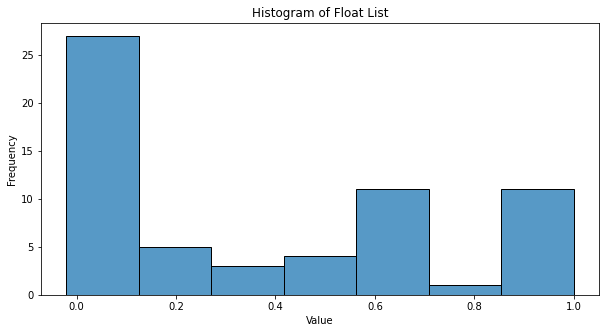

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of floats

# Plotting the histogram
plt.figure(figsize=(10, 5))
sns.histplot(best_scores, kde=False)
plt.title('Histogram of Float List')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [20]:
threshold = 0.4
t_list = []

for val in best_scores :
    if val >= threshold :
        t_list.append(val)
        
print(len(t_list))
    
    
    

27


***
### Get the random model :

In [56]:
import os 
import numpy as np
import random
import pandas as pd 
from itertools import product

path_work = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_work}/raw_metrics.classic_1007.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]

kltypes_TropiGAT = pd.read_csv(f"{path_work}/TropiGAT_KLtypes.tsv", names = ["KL_types"])
kltypes_TropiSeq = pd.read_csv(f"{path_work}/TropiSeq_KLtypes.tsv", names = ["KL_types"])


In [176]:
Counter(working_df["Folds"])

Counter({'right-handed beta-helix': 139,
         '6-bladed beta-propeller': 75,
         'triple-helix': 34,
         'Alpha-alpha toroid': 1})

In [57]:
rhbh_df["Phage"].tolist()

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
1,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
3,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No_associations,0,KL157
5,A1c,A1c_00034,right-handed beta-helix,KL52:0.998 ; KL62:0.993 ; KL128:0.981 ; KL43:0...,0,No_hits,0,KL1
6,A1d,A1d_00009,right-handed beta-helix,KL23:0.983 ; KL60:0.979 ; KL52:0.962 ; KL112:0...,0,No_associations,0,KL20
12,A1g,A1g_00057,right-handed beta-helix,KL128:0.922 ; KL43:0.912 ; KL145:0.898 ; KL18:...,0,No_hits,0,KL16
...,...,...,...,...,...,...,...,...
255,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No_associations,0,"KL102,KL149"
256,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
257,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No_associations,0,"KL102,KL149"
258,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [58]:
path_finetuning = "/media/concha-eloko/Linux/PPT_clean/in_vitro/fine_tuning"

bea_df = pd.read_csv(f"{path_finetuning}/bea_fine_tuning.df", sep = "\t", header = 0)
bea_df["Protein"] = bea_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_bea = set([kltype.strip() for kltypes in bea_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

ferriol_df = pd.read_csv(f"{path_finetuning}/ferriol_fine_tuning.df", sep = "\t", header = 0)
#ferriol_df["Target"] = ferriol_df["Target"].apply(lambda x : x.replace("K", "KL"))
pool_ferriol = set([kltype.strip() for kltypes in ferriol_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

towndsend_df = pd.read_csv(f"{path_finetuning}/towndsend_fine_tuning.df", sep = "\t", header = 0)
towndsend_df["Protein"] = towndsend_df["Protein"].apply(lambda x : x.replace("_", "__"))
pool_towndsend = set([kltype.strip() for kltypes in towndsend_df["Target"] for kltype in kltypes.split(",") if kltype.count("wzi") == 0 if kltype.count("pass") == 0])

dico_matrices = {"ferriol" : {"matrix" : ferriol_df, "pool" : pool_ferriol}, 
                 "bea" : {"matrix": bea_df, "pool" : pool_bea}, 
                 "towndsend" : {"matrix" : towndsend_df, "pool" : pool_towndsend}}

# targets dico : 
dico_hits = {}
for author in dico_matrices :
    matrix = dico_matrices[author]["matrix"]
    for _, row in matrix.iterrows() : 
        for phage in matrix["Phages"].unique() : 
            if phage not in phages_to_ignore :
                all_targets = set()
                targets = matrix[matrix["Phages"] == phage]["Target"].values
                for calls in targets : 
                    actual_targets = [x.strip() for x in calls.split(",")]
                    all_targets.update(actual_targets)
                dico_hits[phage] = all_targets



In [135]:
dico_hits_rhbh = {key:value for key,value in dico_hits.items() if key in rhbh_df["Phage"].tolist()}


In [105]:
def random_selection_and_ranking(elements, dico_matrix, top_n, bootstrap):
    list_bootstrap = []
    combinations_00 = [list(product([phage], targets_list)) for phage, targets_list in dico_matrix.items()]
    combinations = [item for items in combinations_00 for item in items]
    for _ in range(bootstrap):
        track_recall = [0] * (top_n+1)
        count_top_n = 0
        for phage in dico_matrix :
            rank = sorted(
                [(element,rand_num) for element, rand_num in {element:random.random() for element in elements}.items()], #if rand_num > 0.5
                key=lambda x: x[1],
                reverse=True)
            #print(rank)
            for i in range(1,top_n+1) :
                top_i = set([(phage,item[0]) for item in rank[0:i]])
                random_found = len(top_i & set(combinations))
                track_recall[i] = track_recall[i] + random_found
        list_bootstrap.append(track_recall)
    return list_bootstrap
            

In [122]:
from statistics import mean

random_series_full = random_selection_and_ranking(kltypes_TropiGAT["KL_types"], dico_hits_rhbh, 60, 1000)


In [171]:
final_serie_full = []
for i in range(0,60) : 
    tmp_list = [item[i] for item in random_series_full]
    final_serie_full.append(mean(tmp_list))
    
", ".join([str(item) for item in final_serie_full])

'0, 1.172, 2.35, 3.554, 4.758, 5.969, 7.064, 8.205, 9.365, 10.606, 11.789, 12.998, 14.173, 15.358, 16.532, 17.774, 18.983, 20.168, 21.363, 22.476, 23.631, 24.791, 25.916, 27.048, 28.269, 29.466, 30.614, 31.773, 32.919, 34.124, 35.348, 36.556, 37.772, 38.96, 40.128, 41.367, 42.521, 43.68, 44.883, 46.024, 47.163, 48.379, 49.626, 50.749, 51.93, 53.118, 54.359, 55.469, 56.631, 57.801, 58.944, 60.095, 61.278, 62.462, 63.66, 64.906, 66.091, 67.213, 68.411, 69.62'

In [172]:
final_serie_full.index(46.024)

39

In [138]:
from statistics import mean

random_series = random_selection_and_ranking(kltypes_TropiGAT["KL_types"], dico_hits_rhbh, 20, 1000)

final_serie = []
for i in range(0,21) : 
    tmp_list = [item[i] for item in random_series]
    final_serie.append(mean(tmp_list))

In [148]:
tropigat_serie = []
tropiseq_serie = []
total_serie = []

for n in range(1,22) : 
    total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(rhbh_df, top_n = n, to_ignore = phages_to_ignore)
    tropigat_serie.append(len(TropiGAT_good_calls))
    tropiseq_serie.append(len(TropiSeq_good_calls))
    total_serie.append(len(all_calls))



In [149]:
dico_series = {
    "Random": {
        "values": [round(num) for num in final_serie[1:]],
        "color": "#ffdc73",
        "bold": False
    },
    "TropiGAT": {
        "values": tropigat_serie[1:],
        "color": "#344E41",
        "bold": True
    },
    "TropiSeq": {
        "values": tropiseq_serie[1:],
        "color": "#a67c00",
        "bold": True
    },
    "TropiGAT + TropiSeq": {
        "values": total_serie[1:],
        "color": "#940000",
        "bold": True
    }
}

In [150]:
def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
	out = pp.pprint(dico)
	return out 

clean_print(dico_series)

{'Random': {'bold': False,
            'color': '#ffdc73',
            'values': [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24]},
 'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [23, 29, 31, 35, 36, 41, 43, 46, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49,
                         49]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [47, 56, 56, 61, 62, 65, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67,
                                    68, 68, 68, 68]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [36, 42, 42, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                         48]}}


In [170]:
36/128*100

28.125

> The dico :

In [1]:
# m set to 220
dico_series_42 = {
 #'Random (TropiSeq approach)': {'bold': False,
 #                               'color': '#ffdc73',
 #                               'values': [3, 5, 8, 10, 13, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37,
 #                                          40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70, 72,
 #                                          75, 77, 80, 82, 85, 87, 90, 92, 94, 97, 99]},
'Random': {'bold': False,
                                'color': '#A3B18A',
                                'values': [2, 4, 6, 8, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29,
                                           31, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 51, 53, 55,
                                           56, 58, 59, 60, 61, 62, 63, 63, 63, 64, 64]},
 'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [23, 29, 31, 35, 36, 41, 43, 46, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49,
                         49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
                         49, 49]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [47, 56, 56, 61, 62, 65, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67,
                                    68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
                                    68, 68, 68, 68, 68, 68, 68, 68]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [36, 42, 42, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                         48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                         48, 48]}

}

In [153]:
dico_series_42 = {'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [23, 29, 31, 35, 36, 41, 43, 46, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49,
                         49, 49]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [36, 42, 42, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
                         48, 48]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [47, 56, 56, 61, 62, 65, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67,
                                    68, 68, 68, 68]},'Random approach': {'bold': False,
            'color': '#A3B18A',
            'values': [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24]},}


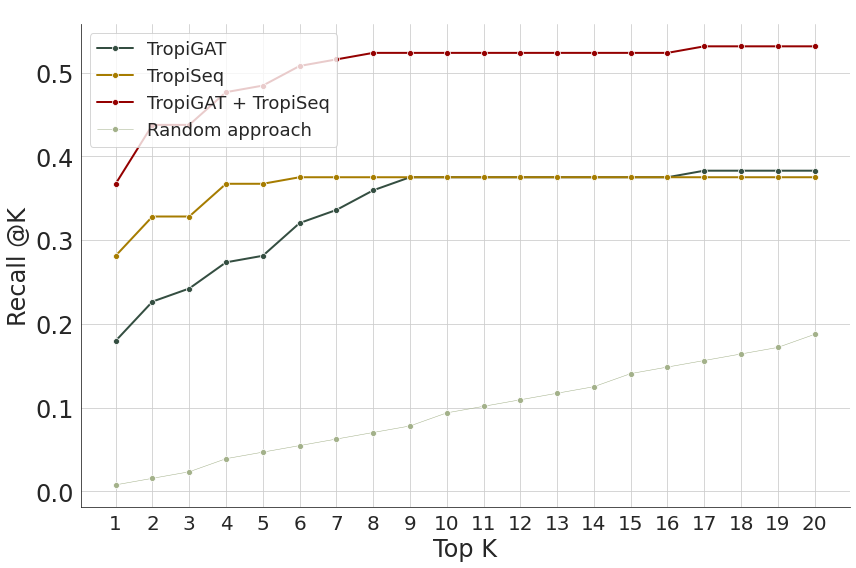

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define colors and line styles

sns.set_style("white")
sns.set_palette("muted")

# Plot each data series
plt.figure(figsize=(12, 8))
for label, series_info in dico_series_42.items():
    #values = series_info["values"]
    values = [num/128 for num in series_info["values"]]
    color = series_info["color"]
    bold = series_info["bold"]
    linestyle = '-' if bold else '-'
    linewidth = 2 if bold else 0.5
    sns.lineplot(x=range(1, len(values) + 1), y=values, label=label, marker='o', linestyle=linestyle, color=color, linewidth=linewidth, markersize=6)

# Customize the plot
plt.title(' ', fontsize=16)
plt.xlabel('Top K', fontsize=24)
plt.ylabel('Recall @K', fontsize=24)
plt.xticks(fontsize=20, rotation=0)  # Rotate x-axis tick labels horizontally
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=18)
plt.grid(True)

# Adjust x-axis ticks to integers
plt.xticks(range(1, len(values) + 1))

# Adjust spines
sns.despine()

plt.tight_layout()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/Recall@N_PPT_Random.1007.lytic.svg', dpi = 500)
plt.show()


***
### Get confusion matrices

In [158]:
import os 
import numpy as np
import random
import pandas as pd 
from collections import Counter
from tqdm import tqdm

path_work = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_work}/raw_metrics.classic_1007.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

In [159]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]
tpl_df = working_df[working_df["Folds"] == "triple-helix"]

> Functions : 

In [160]:
def make_labels_full(pred_df , top_n = 15, to_ignore = []) :
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        # get top n predictions : 
                        predictions_gat = pred_df[pred_df["Phage"] == phage]["TropiGAT_predictions"].values
                        predictions_seq = pred_df[pred_df["Phage"] == phage]["TropiSeq_predictions"].values
                        pred_lvl_1 = [predictions_gat , predictions_seq]
                        # 
                        for predictions in pred_lvl_1 :
                            for calls in predictions : 
                                predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                                top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes

    
def make_labels(pred_df, predictor = "tropigat" , top_n = 15, to_ignore = []) :
    dico_pred = {"tropigat" : "TropiGAT_predictions" ,
                 "tropiseq" : "TropiSeq_predictions"}
    col = dico_pred[predictor]
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        predictions = pred_df[pred_df["Phage"] == phage][col].values
                        for calls in predictions : 
                            predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                            top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes


def decript_dic (sorted_dict , labels_tropigat, count_kltypes) :
    print(f"KL type\tCount\tF1\tAccuracy\tRecall\tPrecision\tAUC\tMCC\n")
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")


def decript_dic_sober (sorted_dict , labels_tropigat, count_kltypes) :
    print(f"KL type\tCount\tRecall\tPrecision\tAUC\tMCC\n")
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    #f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    #accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")


def get_MCC_lytic (sorted_dict , labels_tropigat, count_kltypes) :
    dico_MCC = {}
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] >= 0 :
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    dico_MCC[kltype] = {"lytic_phages" :{"MCC" : mcc , "Recall" : recall, "Count" : count_kltypes[kltype]}}
                    #print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
        except ValueError : 
            print(kltype , "error", sep = "\t")
    return dico_MCC


def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls


def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 150, sort_dicts = True, compact = False)
	out = pp.pprint(dico)
	return out 



> Work : 

In [161]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)

DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

KLtypes = [kltype for kltype in dico_prophage_count if dico_prophage_count[kltype] >= 10]

In [162]:
from statistics import mean 

all_counts = [value for key, value in count_kltypes_tropigat.items()]

mean(all_counts)

NameError: name 'count_kltypes_tropigat' is not defined

In [24]:
44/86

0.5116279069767442

> Matrices TropiGAT : 

In [163]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/ensemble_0702_log_files/"
average_metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/Metric_Report.0702.clean.tsv", sep = "\t", header = 0)


In [89]:
average_metric_df

,KL_type,model_version,n_prophages,precision,recall,Accuracy,F1_score,AUC,MCC
0,KL1,KL1__4,190,0.8232,0.4526,0.8930,0.5772,0.8753,0.5570
1,KL2,KL2__4,351,0.7298,0.8743,0.9133,0.7847,0.9506,0.7457
2,KL3,KL3__5,145,0.6630,0.9857,0.9093,0.7872,0.9853,0.7610
3,KL5,KL5__3,28,0.5400,0.8000,0.8375,0.6271,0.8357,0.5648
4,KL7,KL7__1,37,0.4700,1.0000,0.8286,0.6348,0.9222,0.6124
...,...,...,...,...,...,...,...,...,...
62,KL136,KL136__4,32,0.4767,0.8000,0.8211,0.5937,0.9000,0.5193
63,KL145,KL145__2,29,0.3217,0.9000,0.7125,0.4676,0.8286,0.4162
64,KL149,KL149__2,70,0.5063,0.8857,0.8286,0.6353,0.9273,0.5801
65,KL151,KL151__3,61,0.5488,0.9000,0.8500,0.6734,0.9111,0.6228


In [164]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]

In [167]:
# rhbh_df
# bp_df
# working_df


sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(rhbh_df, predictor = "tropigat")
dico_mcc_tropigat = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
#decript_dic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 178.91it/s]
/media/concha-eloko/Linux/conda_envs/torch_geometric/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/torch_geometric/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/torch_geometric/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defi

In [168]:
dico_mcc_tropigat

{'KL1': {'lytic_phages': {'MCC': -0.02165232674872103,
   'Recall': 0.0,
   'Count': 3}},
 'KL2': {'lytic_phages': {'MCC': 0.38504221028220603,
   'Recall': 0.625,
   'Count': 8}},
 'KL3': {'lytic_phages': {'MCC': 0.5, 'Recall': 1.0, 'Count': 3}},
 'KL4': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL5': {'lytic_phages': {'MCC': -0.020833333333333332,
   'Recall': 0.0,
   'Count': 1}},
 'KL6': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL7': {'lytic_phages': {'MCC': -0.036860489038724284,
   'Recall': 0.0,
   'Count': 1}},
 'KL8': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL9': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL10': {'lytic_phages': {'MCC': 0.3042903097250923,
   'Recall': 1.0,
   'Count': 1}},
 'KL11': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL12': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL13': {'lytic_phages': {'MCC': 0.35484652451826487,
   'Recall': 1.0,
   '

In [92]:
Counter(labels_tropigat["KL102"]["y_pred"])

Counter({1: 21})

In [96]:
error_kltype = []
for kltype in dico_mcc_tropigat : 
    try : 
        mcc_train = average_metric_df[average_metric_df["KL_type"] == kltype]["MCC"].values[0]
        count = average_metric_df[average_metric_df["KL_type"] == kltype]["n_prophages"].values[0]
        dico_mcc_tropigat[kltype].update({"prophage" : {"MCC" : mcc_train, "Count" : count}})
    except Exception as e : 
        print(kltype , e)
        error_kltype.append(kltype)
    

KL4 index 0 is out of bounds for axis 0 with size 0
KL6 index 0 is out of bounds for axis 0 with size 0
KL11 index 0 is out of bounds for axis 0 with size 0
KL20 index 0 is out of bounds for axis 0 with size 0
KL26 index 0 is out of bounds for axis 0 with size 0
KL31 index 0 is out of bounds for axis 0 with size 0
KL33 index 0 is out of bounds for axis 0 with size 0
KL35 index 0 is out of bounds for axis 0 with size 0
KL37 index 0 is out of bounds for axis 0 with size 0
KL41 index 0 is out of bounds for axis 0 with size 0
KL42 index 0 is out of bounds for axis 0 with size 0
KL49 index 0 is out of bounds for axis 0 with size 0
KL54 index 0 is out of bounds for axis 0 with size 0
KL56 index 0 is out of bounds for axis 0 with size 0
KL58 index 0 is out of bounds for axis 0 with size 0
KL59 index 0 is out of bounds for axis 0 with size 0
KL61 index 0 is out of bounds for axis 0 with size 0
KL66 index 0 is out of bounds for axis 0 with size 0
KL67 index 0 is out of bounds for axis 0 with si

In [97]:
mcc_lytic = [value["lytic_phages"]["MCC"] for key,value in dico_mcc_tropigat.items() if key not in error_kltype]
mcc_prophage = [value["prophage"]["MCC"] for key,value in dico_mcc_tropigat.items() if key not in error_kltype]
kltypes_list = [kltype for kltype in list(dico_mcc_tropigat.keys()) if kltype not in error_kltype]

df_tropigat = pd.DataFrame([kltypes_list,mcc_lytic, mcc_prophage]).T
df_tropigat.columns = ["KL type", "MCC_lytic", "MCC_prophage"]

df_tropigat

,KL type,MCC_lytic,MCC_prophage
0,KL1,-0.021652,0.557
1,KL2,0.385042,0.7457
2,KL3,0.5,0.761
3,KL5,-0.020833,0.5648
4,KL7,-0.03686,0.6124
5,KL8,0.0,0.4398
6,KL9,0.0,0.037
7,KL10,0.30429,0.5565
8,KL12,0.0,0.5198
9,KL13,0.354847,0.5285


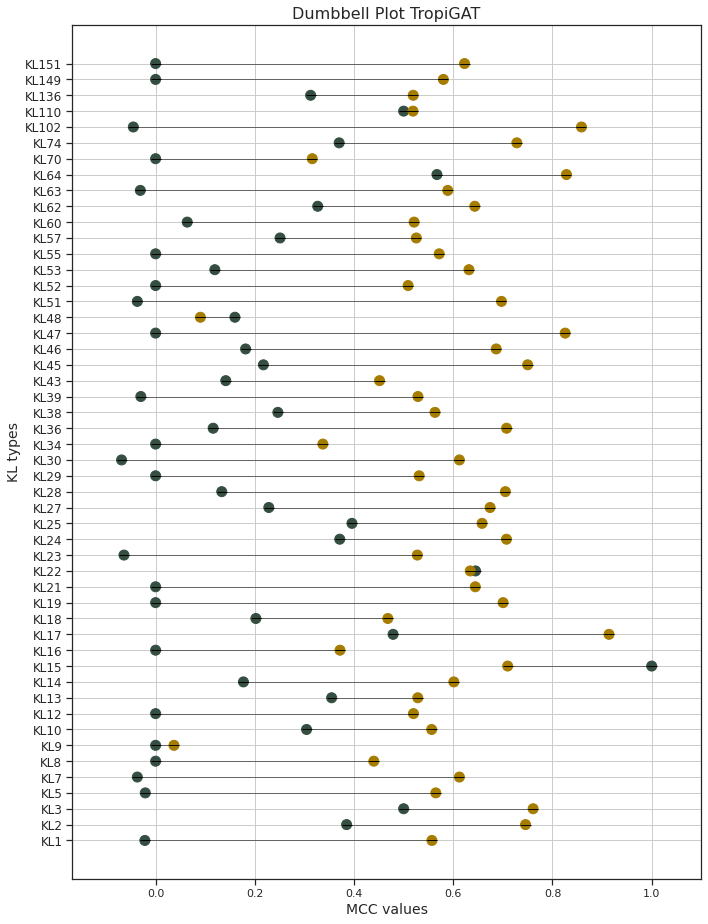

In [99]:
from scipy.stats import pearsonr
# Set seaborn style
sns.set(style="ticks")

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 13))

# Plot MCC_lytic and MCC_prophage values for each KL type
for i, row in df_tropigat.iterrows():
    ax.scatter([row["MCC_lytic"], row["MCC_prophage"]], [i, i], color=['#344e41ff', '#a67c00ff'], s=100)  
    ax.plot([row["MCC_lytic"], row["MCC_prophage"]], [i, i], marker='_', color='black', markersize=10, linewidth= 0.5) 

# Set y-ticks and labels
ax.set_yticks(range(len(df_tropigat)))
ax.set_yticklabels(df_tropigat["KL type"], fontsize=12)  

# Add labels and title
ax.set_xlabel('MCC values', fontsize=14) 
ax.set_ylabel('KL types', fontsize=14)  
ax.set_title('Dumbbell Plot TropiGAT', fontsize=16) 

# Set x-limits to shorten the line
min_mcc = min(df_tropigat["MCC_lytic"].min(), df_tropigat["MCC_prophage"].min())
max_mcc = max(df_tropigat["MCC_lytic"].max(), df_tropigat["MCC_prophage"].max())
ax.set_xlim(min_mcc - 0.1, max_mcc + 0.1)  

# Show plot
plt.grid(True)
plt.tight_layout()
#sns.despine()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/dumbbell.TropiGAT.2806.svg', dpi = 500)
plt.show()


#correlation_coefficient, p_value = pearsonr(df_tropigat["MCC_lytic"], df_tropigat["MCC_prophage"])

#print("Pearson correlation coefficient:", correlation_coefficient)
#print("P-value:", p_value)


> Matrices TropiSeq : 

In [100]:
import pandas as pd 
import os 

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info"

header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.75.0702.tsv", sep = "\t", header = 0)

seqbased_df

,KL_type,n_prophages,MCC,F1,recall,Accuracy,AUC
0,KL41,10,0.000000,0.000000,0.000000,0.833333,0.500000
1,KL30,93,0.390511,0.466667,0.411765,0.857143,0.674303
2,KL6,12,0.000000,0.000000,0.000000,0.800000,0.500000
3,KL19,73,0.747625,0.758621,0.611111,0.924731,0.805556
4,KL25,269,0.824502,0.851485,0.877551,0.953560,0.922352
...,...,...,...,...,...,...,...
84,KL20,18,-0.118345,0.000000,0.000000,0.727273,0.470588
85,KL142,14,-0.108465,0.000000,0.000000,0.777778,0.466667
86,KL58,6,0.000000,0.000000,0.000000,0.750000,0.500000
87,KL124,12,0.534522,0.500000,0.333333,0.866667,0.666667


In [115]:

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropiseq")
dico_mcc_tropiseq = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 283.34it/s]


In [116]:
dico_mcc_tropiseq

{'KL1': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 3}},
 'KL2': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 12}},
 'KL3': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 8}},
 'KL4': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 7}},
 'KL5': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL6': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL7': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 3}},
 'KL8': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL9': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0}},
 'KL10': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL11': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 3}},
 'KL12': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1}},
 'KL13': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 4}},
 'KL14': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 9}},
 'KL15': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'C

In [106]:
error_kltype = []
for kltype in dico_mcc_tropiseq : 
    try : 
        mcc_train = seqbased_df[seqbased_df["KL_type"] == kltype]["MCC"].values[0]
        count = seqbased_df[seqbased_df["KL_type"] == kltype]["n_prophages"].values[0]
        dico_mcc_tropiseq[kltype].update({"prophage" : {"MCC" : mcc_train, "Count" : count}})
    except Exception as e :
        print(e, kltype)
        error_kltype.append(kltype)

dico_mcc_tropiseq

index 0 is out of bounds for axis 0 with size 0 KL11
index 0 is out of bounds for axis 0 with size 0 KL29
index 0 is out of bounds for axis 0 with size 0 KL33
index 0 is out of bounds for axis 0 with size 0 KL34
index 0 is out of bounds for axis 0 with size 0 KL37
index 0 is out of bounds for axis 0 with size 0 KL42
index 0 is out of bounds for axis 0 with size 0 KL49
index 0 is out of bounds for axis 0 with size 0 KL52
index 0 is out of bounds for axis 0 with size 0 KL59
index 0 is out of bounds for axis 0 with size 0 KL66
index 0 is out of bounds for axis 0 with size 0 KL71
index 0 is out of bounds for axis 0 with size 0 KL82
index 0 is out of bounds for axis 0 with size 0 KL126
index 0 is out of bounds for axis 0 with size 0 KL134
index 0 is out of bounds for axis 0 with size 0 KL144
index 0 is out of bounds for axis 0 with size 0 KL158


{'KL1': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 3},
  'prophage': {'MCC': 0.689272416907325, 'Count': 190}},
 'KL2': {'lytic_phages': {'MCC': 0.5947210958240693,
   'Recall': 0.375,
   'Count': 8},
  'prophage': {'MCC': 0.819829538453252, 'Count': 351}},
 'KL3': {'lytic_phages': {'MCC': 1.0, 'Recall': 1.0, 'Count': 3},
  'prophage': {'MCC': 0.9772845968667996, 'Count': 145}},
 'KL4': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 0},
  'prophage': {'MCC': 0.53748384988657, 'Count': 13}},
 'KL5': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1},
  'prophage': {'MCC': 1.0, 'Count': 28}},
 'KL6': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1},
  'prophage': {'MCC': 0.0, 'Count': 12}},
 'KL7': {'lytic_phages': {'MCC': 0.0, 'Recall': 0.0, 'Count': 1},
  'prophage': {'MCC': 0.823754471047914, 'Count': 37}},
 'KL8': {'lytic_phages': {'MCC': -0.020833333333333332,
   'Recall': 0.0,
   'Count': 1},
  'prophage': {'MCC': 0.0, 'Count': 20}},
 'KL9': {'lytic_

In [107]:
mcc_lytic = [value["lytic_phages"]["MCC"] for key,value in dico_mcc_tropiseq.items() if key not in error_kltype]
mcc_prophage = [value["prophage"]["MCC"] for key,value in dico_mcc_tropiseq.items() if key not in error_kltype]
kltypes_list = [kltype for kltype in list(dico_mcc_tropiseq.keys()) if kltype not in error_kltype]

df_tropiseq = pd.DataFrame([kltypes_list,mcc_lytic, mcc_prophage]).T
df_tropiseq.columns = ["KL type", "MCC_lytic", "MCC_prophage"]

df_tropiseq

,KL type,MCC_lytic,MCC_prophage
0,KL1,0.0,0.689272
1,KL2,0.594721,0.81983
2,KL3,1.0,0.977285
3,KL4,0.0,0.537484
4,KL5,0.0,1.0
...,...,...,...
58,KL139,1.0,0.438529
59,KL140,0.0,0.786796
60,KL149,0.0,0.932443
61,KL151,1.0,0.965778


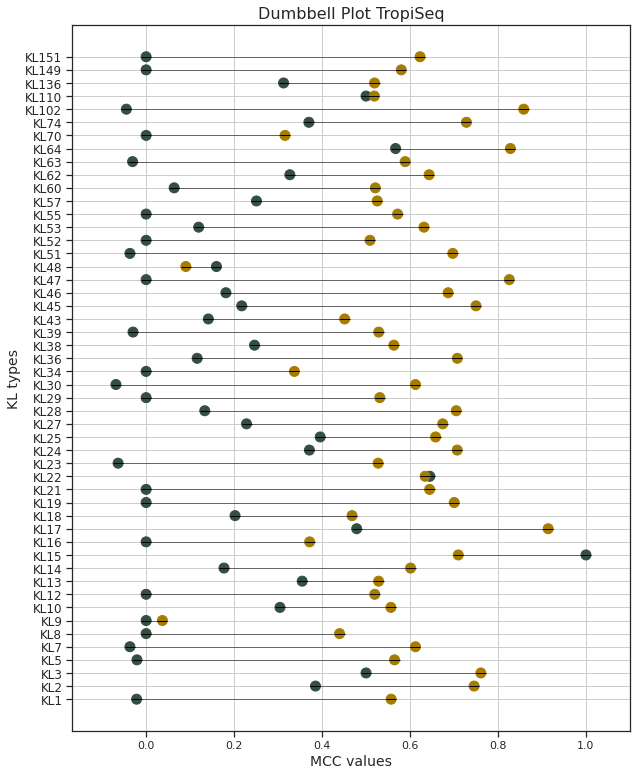

0.3257375323617612


In [108]:
from scipy.stats import pearsonr
# Set seaborn style
sns.set(style="ticks")

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 13))

# Plot MCC_lytic and MCC_prophage values for each KL type
for i, row in df_tropigat.iterrows():
    ax.scatter([row["MCC_lytic"], row["MCC_prophage"]], [i, i], color=['#344e41ff', '#a67c00ff'], s=100)  
    ax.plot([row["MCC_lytic"], row["MCC_prophage"]], [i, i], marker='_', color='black', markersize=10, linewidth= 0.5) 

# Set y-ticks and labels
ax.set_yticks(range(len(df_tropigat)))
ax.set_yticklabels(df_tropigat["KL type"], fontsize=12)  

# Add labels and title
ax.set_xlabel('MCC values', fontsize=14) 
ax.set_ylabel('KL types', fontsize=14)  
ax.set_title('Dumbbell Plot TropiSeq', fontsize=16) 

# Set x-limits to shorten the line
min_mcc = min(df_tropigat["MCC_lytic"].min(), df_tropigat["MCC_prophage"].min())
max_mcc = max(df_tropigat["MCC_lytic"].max(), df_tropigat["MCC_prophage"].max())
ax.set_xlim(min_mcc - 0.1, max_mcc + 0.1)  

# Show plot
plt.grid(True)
#plt.tight_layout()
#sns.despine()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/dumbbell.TropiSeq.2806.svg', dpi = 500)
plt.show()


correlation_coefficient, p_value = pearsonr(df_tropigat["MCC_lytic"], df_tropigat["MCC_prophage"])
print(correlation_coefficient)

***